# Data Acquisition and Processing Systems (DaPS) (ELEC0136)    
### Final Assignment
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests

from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM,Dense
from keras.metrics import MeanSquaredError,MeanAbsoluteError

## Task 1: Data Acquisition
I collected three datasets in total. For the historical stock price, I provide two methods to acquire it. One is downloading it from the website, the other is using API. Two external datasets are used in this project: quartly revenue and US monthly GDP. Both are downloaded from websites.

### 1. Download data from websites

MSFT stock prices: https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1491004800&period2=1619827200&interval=1d&events=history&includeAdjustedClose=true

US monthly GDP: https://cdn.ihsmarkit.com/www/default/1020/US-Monthly-GDP-History-Data.xlsx

MSFT quartly revenue: https://www.microsoft.com/en-us/Investor/earnings/FY-21-Q3/press-release-webcast (You need to change the quarter number everytime.)
### 2. Use an API
API: http://alphavantage.co

In [2]:
#download data from the website
def acquire_web(url):
    #To avild being forbidden, pretend to be a host
    headers={
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.137 Safari/537.36 LBBROWSER'
        } 
    data=requests.get(url,headers=headers)
    return data

In [3]:
#acquire stock price from API
def acquire_API():
    url='https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo'
    r = requests.get(url)
    data = r.json()
    return data

## Task 2: Data storage
I stored data as csv locally in my computer. The csv file is uploaded as 'multidata.csv' in github, which contains all cleaned data. 

In [4]:
#store data as csv file
def store(data,docname):
    with open(docname,'wb') as file:
        file.write(data.content)

## Task 3 : Data Preprocessing
### 1. Data cleaning
Missing data: GDP and revenue are not stored by day, so I copy the data for everyday in a month/quarter. All data are stored in 'multidata.csv'.

Outliers: I plot the box diagrams of three datasets (will be shown in task 4), which show that there're no outliers.
### 2. Data visualization
I plot three datasets directly. General trend can be shown in the pictures.
### 3. Data transformation
I did data normalization in this part. As magnitudes of all datasets are different. 

In [5]:
def process(data):
    #read data
    df=pd.read_csv(data)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    
    #plot price
    price=df['Close']
    plt.figure(figsize=(16,8))
    plt.plot(price, label='Close Price history')
    plt.legend()
    plt.grid()
    plt.savefig('price.jpg')
    
    #plot revenue
    revenue=df['Revenue']
    plt.figure(figsize=(16,8))
    plt.plot(revenue, label='Quartly revenue')
    plt.legend()
    plt.grid()
    plt.savefig('revenue.jpg')
    
    #plot gdp
    gdp=df['GDP']
    plt.figure(figsize=(16,8))
    plt.plot(gdp, label='US monthly gdp')
    plt.legend()
    plt.grid()
    plt.savefig('gdp.jpg')
    
    return price,revenue,gdp

In [6]:
def normalization(data):
    data=data.values.reshape(data.shape[0],1)
    sca=MinMaxScaler()
    data=sca.fit_transform(data)
    return data,sca

## Task 4: Data Exploration
### 1. EDA
In this part, codes related to boxplots and covariance computing are provided.
### 2. Hypothesis testing
After data visualisation and EDA, I recognize that the price of stock has a trend of increasing generally. So I suppose the hypothesis that today's stock is more likely to be higher than yesterday rather than be lower. Codes provided in this part will demonstrate that we should accept the hypothesis. More details shown in the report.

In [7]:
def eda(price,revenue,gdp):
    #price boxplots
    plt.figure(figsize=(16,8))
    sns.boxplot(price)
    plt.savefig('pricebox.jpg')
    
    #revenue boxplots
    plt.figure(figsize=(16,8))
    sns.boxplot(revenue)
    plt.savefig('revenuebox.jpg')
    
    #gdp boxplots
    plt.figure(figsize=(16,8))
    sns.boxplot(gdp)
    plt.savefig('gdpbox.jpg')
    
    #compute covariance
    print('Covariance between price and revenue: ',np.cov(price,revenue))
    print('Covariance between price and gdp: ',np.cov(price,gdp))
    print('Covariance between gdp and revenue: ',np.cov(gdp,revenue))

In [8]:
#H0:Stock price isn't increasing:u<=0
#H1:Stock price is increasing:u>0
def ht(price):
    #compute differences
    diff=[]
    for i in range(1,len(price)):
        diff.append(price[i]-price[i-1])
    
    #plot distribution
    plt.figure(figsize=(16,8))
    sns.distplot(diff)
    plt.savefig('diffdist.jpg')
    
    #compute z
    diff=np.array(diff)
    x=diff.mean()
    s=diff.std()
    n=len(diff)
    z=x/(s/math.sqrt(n))
    
    #check table and get p
    p=1-0.9798
    
    #set a=0.05,pritn results
    if p<0.05:
        print('Stock price is increasing.')
    else:
        print('Stock price is not increasing')

## Task 5: Data inference
First are some processings of data to convert them into proper inputs. Train set and test set splitting are included. Then, two models are built:

1. Model using stocks

2. Model using stacks and two external data sources

After creating and training models, I use several matrics to evaluate models. Two trained models have already been uploaded to github. 

Then models are used to predict stocks of May 2021. True values of stock prices of May are stored in 'MSFT_21May.csv'. Visualizations of results are provided.

In [9]:
#split x and y for model1 (single input)
def xy1(data):
    x=[]
    y=[]
    for i in range(30,len(data)):
        x.append(data[i-30:i,0])
        y.append(data[i,0])
    return np.array(x),np.array(y)

#split x and y for model2 (multiple inputs)
def xy2(price,revenue,gdp):
    data=np.hstack((price,revenue,gdp))
    x=[]
    y=[]
    for i in range(30,len(data)):
        x.append(data[i-30:i])
        y.append(price[i,0])
    return np.array(x),np.array(y)

In [10]:
#split train and test
def traintest(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3)
    return x_train,x_test,y_train,y_test

In [11]:
def build_model1():
    model1 = Sequential()
    model1.add(LSTM(units=50, return_sequences=True, input_shape=(30,1)))
    model1.add(LSTM(units=50))
    model1.add(Dense(1))
    return model1    

In [12]:
def build_model2():
    model2 = Sequential()
    model2.add(LSTM(units=50, return_sequences=True, input_shape=(30,3)))
    model2.add(LSTM(units=50))
    model2.add(Dense(1))
    return model2

In [13]:
def train(model, x_train,y_train):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
    return model

In [14]:
def predict(model,x):
    return model.predict(x)

In [15]:
#evaluate the model using different metrics
def evaluate(model, y_predict,y):
    #MSE
    m = MeanSquaredError()
    m.update_state(y_predict,y)
    print('MSE: ',m.result().numpy())
    
    #MAE
    a=MeanAbsoluteError()
    a.update_state(y_predict,y)
    print('MAE: ',a.result().numpy())
    
    #R2
    print('R2 score: ',r2_score(y_predict,y))
    
    #residual
    residual=np.ravel(y_predict)-y
    print('residual mean: ',np.mean(residual))
    print('residual median: ',np.median(residual))
    print('skew: ',skew(residual))

In [16]:
#plot prediction results
def plotresults(model,name,y_predict,y):
    plt.figure(figsize=(16,8))
    plt.plot(y,label='true value')
    plt.plot(y_predict,label='predict value')
    plt.legend()
    plt.grid()
    plt.savefig(name+'.jpg')

<div class="alert alert-heading alert-danger">

## Autorun

</div>

In [17]:
def main():
    #data processing
    data='multidata.csv'
    price,revenue,gdp=process(data)
    eda(price,revenue,gdp)
    ht(price)
    
    #normalization
    price,sca_p=normalization(price)
    revenue,sca_r=normalization(revenue)
    gdp,sca_g=normalization(gdp)
    
    #model1:train and test
    x1,y1=xy1(price)
    x1_train,x1_test,y1_train,y1_test=traintest(x1,y1)
    model1=load_model('model1_new.h5')
    #model1=build_model1()
    #train(model1,x1_train,y1_train)
    y1_predict=predict(model1,x1_test)
    print('model1 evaluation using test set:')
    evaluate(model1,y1_predict,y1_test)
    y1_predict_all=predict(model1,x1)
    plotresults(model1,'model1',y1_predict_all,y1)
    
    #model2:train and test
    x2,y2=xy2(price,revenue,gdp)
    x2_train,x2_test,y2_train,y2_test=traintest(x2,y2)
    model2=load_model('model2_new.h5')
    #model2=build_model2()
    #train(model2,x2_train,y2_train)
    y2_predict=predict(model2,x2_test)
    print('model2 evaluation using test set:')
    evaluate(model2,y2_predict,y2_test)
    y2_predict_all=predict(model2,x2)
    plotresults(model1,'model2',y2_predict_all,y2)
    
    #prediction for May 2021
    May=pd.read_csv('MSFT_21May.csv')
    y_May=May['Close'].values.reshape(May.shape[0],1)
    
    #prediction using model1
    May1=[]
    ans1=x1[-1:]
    cur1=y1[-1]
    for _ in range(len(y_May)):
        ans1[0]=np.hstack((ans1[0][1:],cur1))
        cur1=predict(model1,ans1)[0][0]
        May1.append(cur1)
    May1=np.array(May1) 
    a1=May1.reshape(May1.shape[0],1)
    May1=sca_p.inverse_transform(a1)
    plotresults(model1,'model1_May',May1,y_May)

    #prediction using model2
    ans2=x2[-1:]
    cur2=y2[-1]
    May2=[]
    for _ in range(len(y_May)):
        ans2[0]=np.vstack((ans2[0][1:],np.array([cur2,1,1])))
        cur2=predict(model2,ans2)[0][0]
        May2.append(cur2)
    May2=np.array(May2) 
    a2=May2.reshape(May2.shape[0],1)
    May2=sca_p.inverse_transform(a2)
    plotresults(model2,'model2_May',May2,y_May)

c:\users\11597\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\11597\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\11597\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resu

Covariance between price and revenue:  [[2855.48873815  287.06696241]
 [ 287.06696241   32.63131335]]
Covariance between price and gdp:  [[  2855.48873815  31612.44328137]
 [ 31612.44328137 810174.23482714]]
Covariance between gdp and revenue:  [[8.10174235e+05 3.80401503e+03]
 [3.80401503e+03 3.26313134e+01]]


c:\users\11597\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Stock price is increasing.
model1 evaluation using test set:
MSE:  0.00022229318
MAE:  0.011218533
R2 score:  0.996462710229461
residual mean:  0.00745473645639221
residual median:  0.008401451476999722
skew:  0.6927680603286904
model2 evaluation using test set:
MSE:  0.0001732461
MAE:  0.0086082965
R2 score:  0.9973891096162949
residual mean:  0.00034383009385864004
residual median:  -0.001617877402129736
skew:  2.0614344247902814


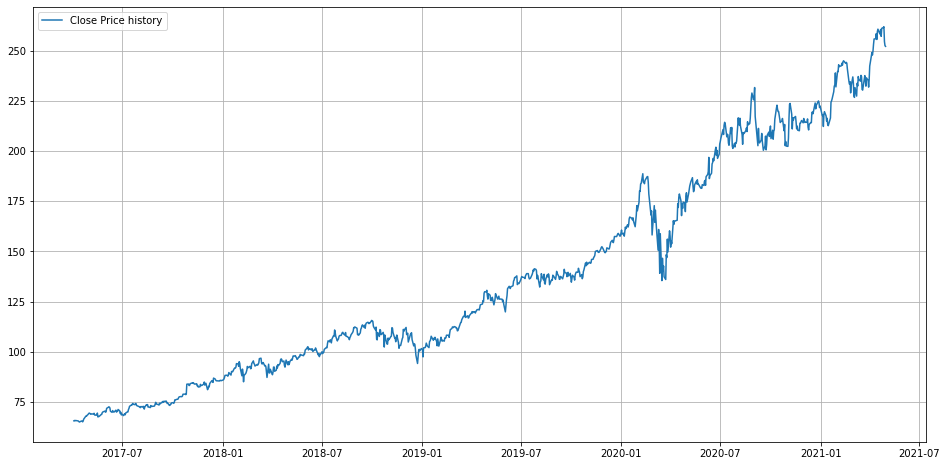

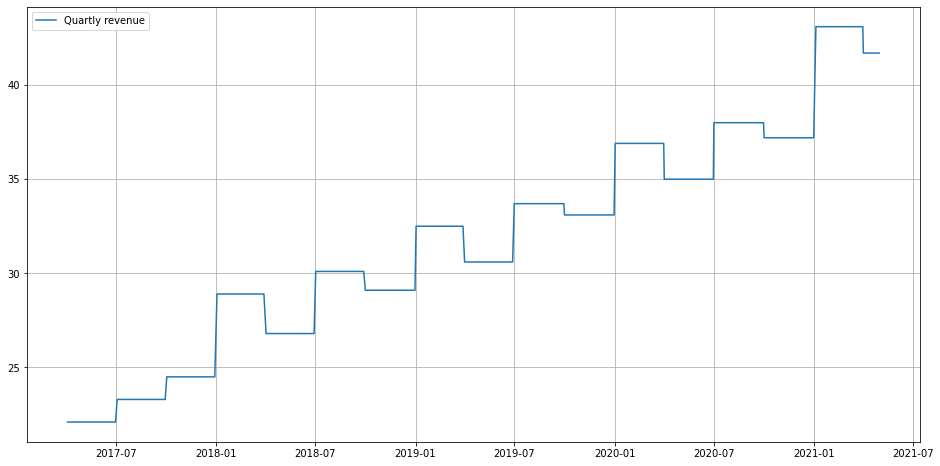

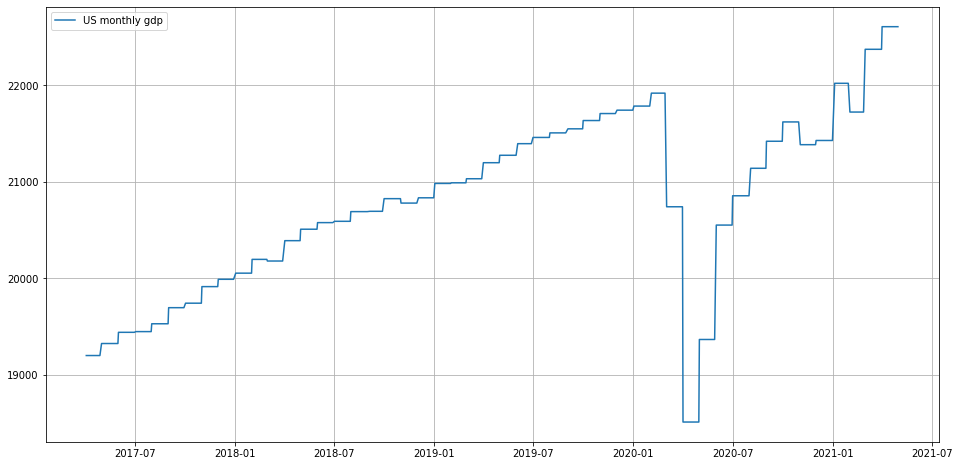

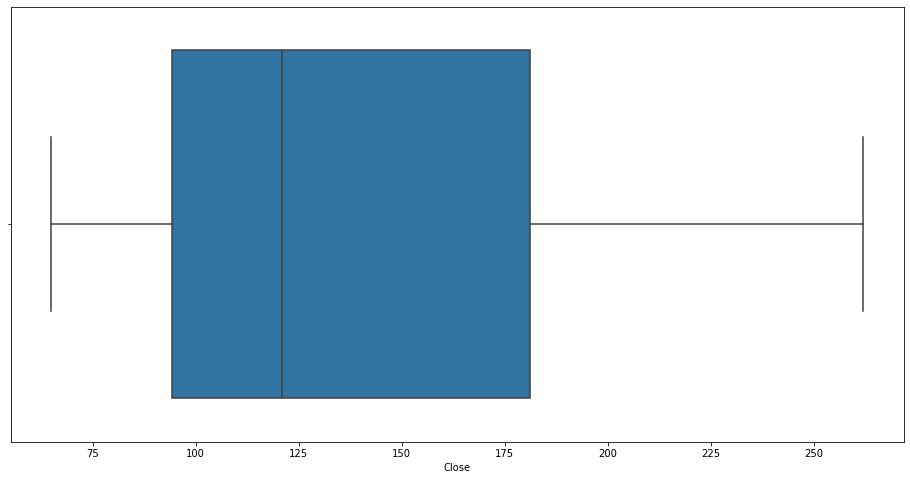

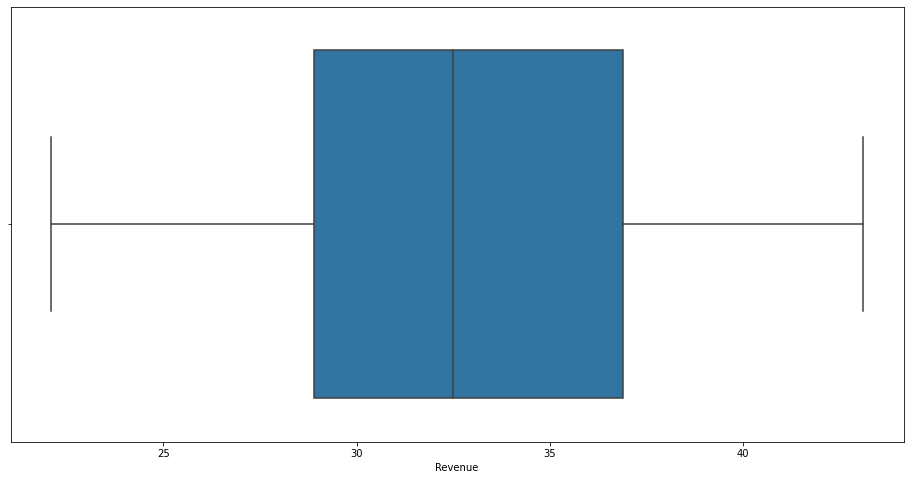

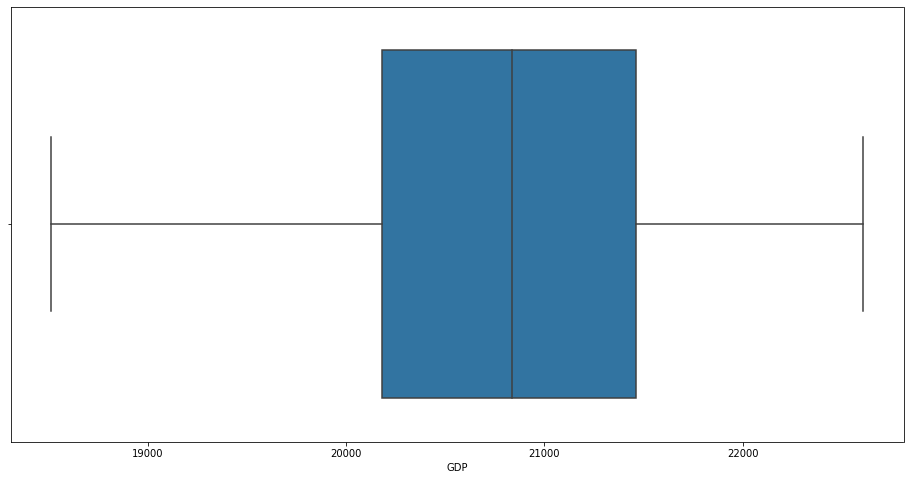

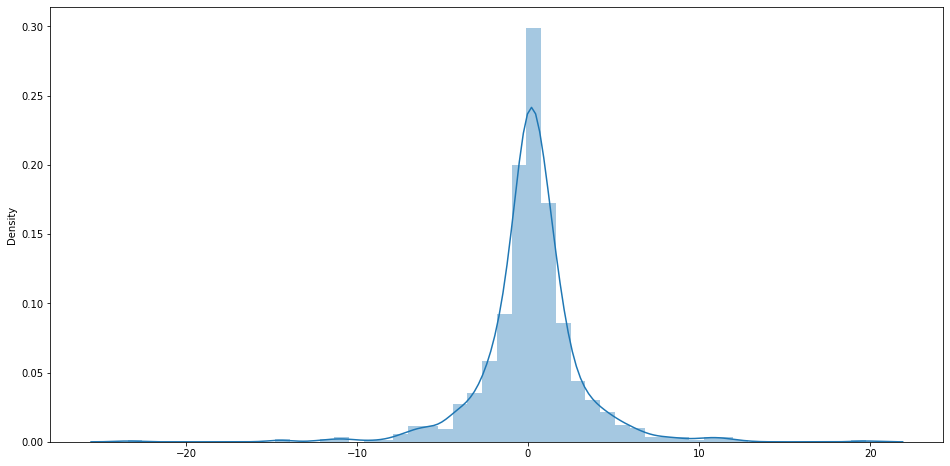

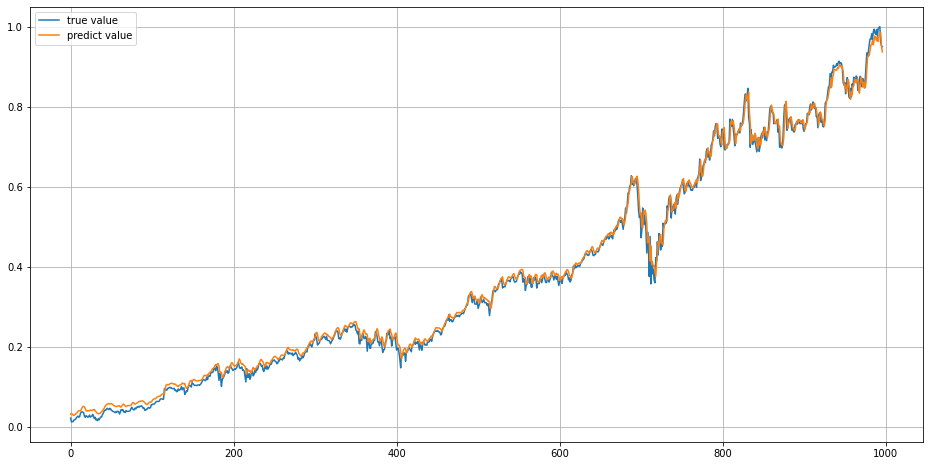

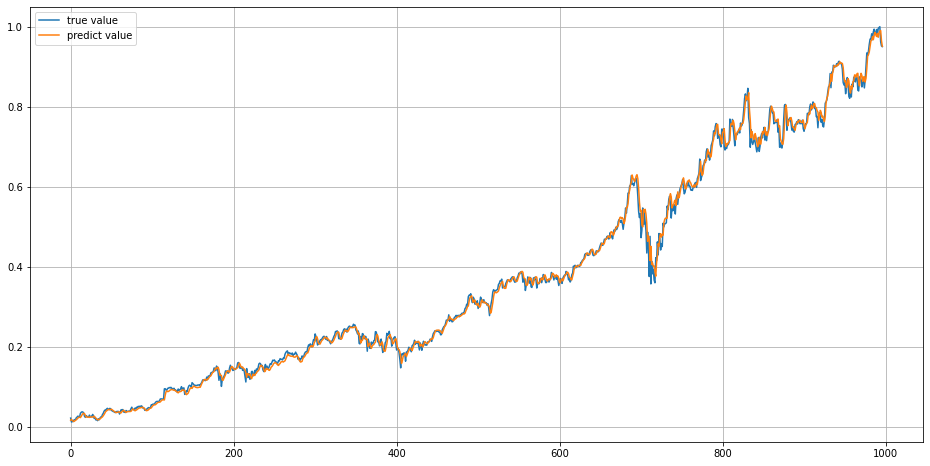

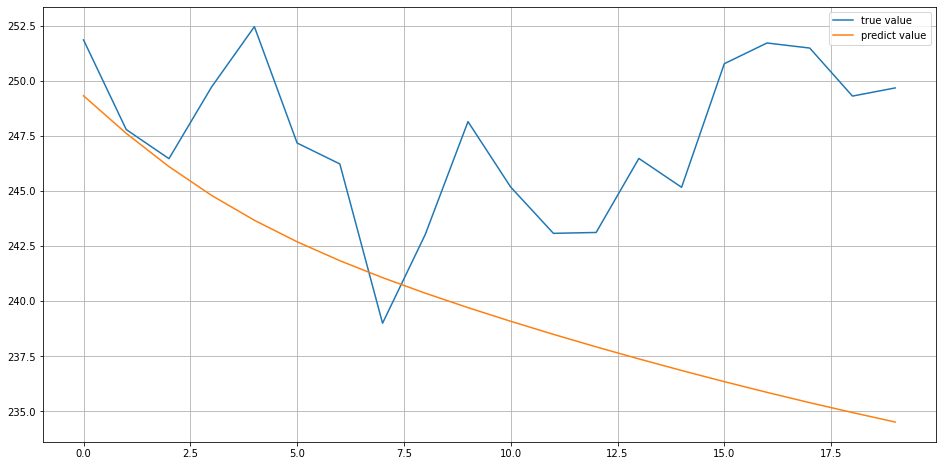

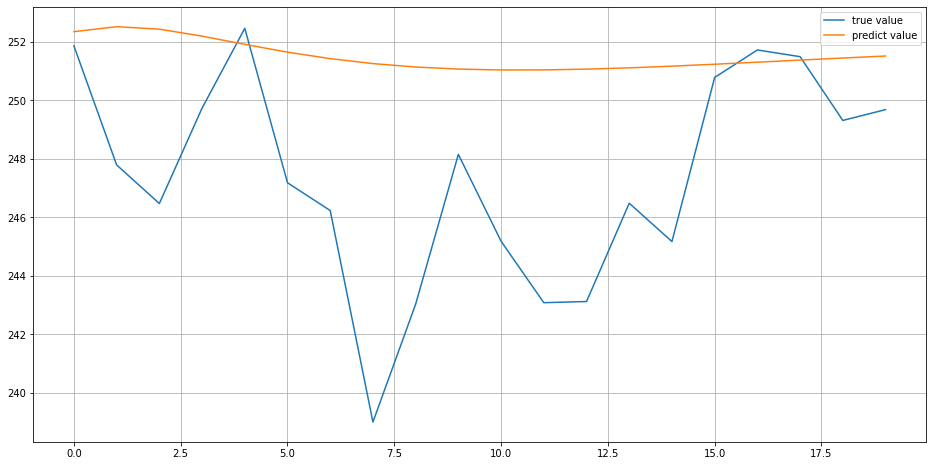

In [18]:
main()